<a href="https://colab.research.google.com/github/norebese/kdt-task/blob/main/20_%EA%B0%84%EB%8B%A8%ED%95%9C_CNN_%EB%AA%A8%EB%8D%B8_%EB%A7%8C%EB%93%A4%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim

In [21]:
# 배치크기 * 채널(1: 그래이스케일, 3: 컬러) * 너비 * 높이
inputs = torch.Tensor(1, 1, 28, 28)
print(inputs.shape)

torch.Size([1, 1, 28, 28])


In [22]:
# 첫번째 Conv2D
conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding='same')
out = conv1(inputs)
print(out.shape)

torch.Size([1, 32, 28, 28])


In [23]:
# 첫번째 MaxPool2D
pool = nn.MaxPool2d(kernel_size=2)
out = pool(out)
print(out.shape)

torch.Size([1, 32, 14, 14])


In [24]:
# 두번째 Conv2D
conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='same')
out = conv2(out)
print(out.shape)

torch.Size([1, 64, 14, 14])


In [25]:
# 두번째 MaxPool2D
pool = nn.MaxPool2d(kernel_size=2)
out = pool(out)
print(out.shape)

torch.Size([1, 64, 7, 7])


In [26]:
flatten = nn.Flatten()
out = flatten(out)
print(out.shape) # 64 * 7 * 7

torch.Size([1, 3136])


In [27]:
fc = nn.Linear(3136, 10)
out = fc(out)
print(out.shape)

torch.Size([1, 10])


### CNN으로 MNIST 분류하기

In [28]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [29]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [30]:
train_data = datasets.MNIST(
    root='data',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 12508988.19it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 341734.61it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3145401.32it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4371392.56it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [31]:
test_data = datasets.MNIST(
    root='data',
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

In [32]:
print(train_data)
print(test_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


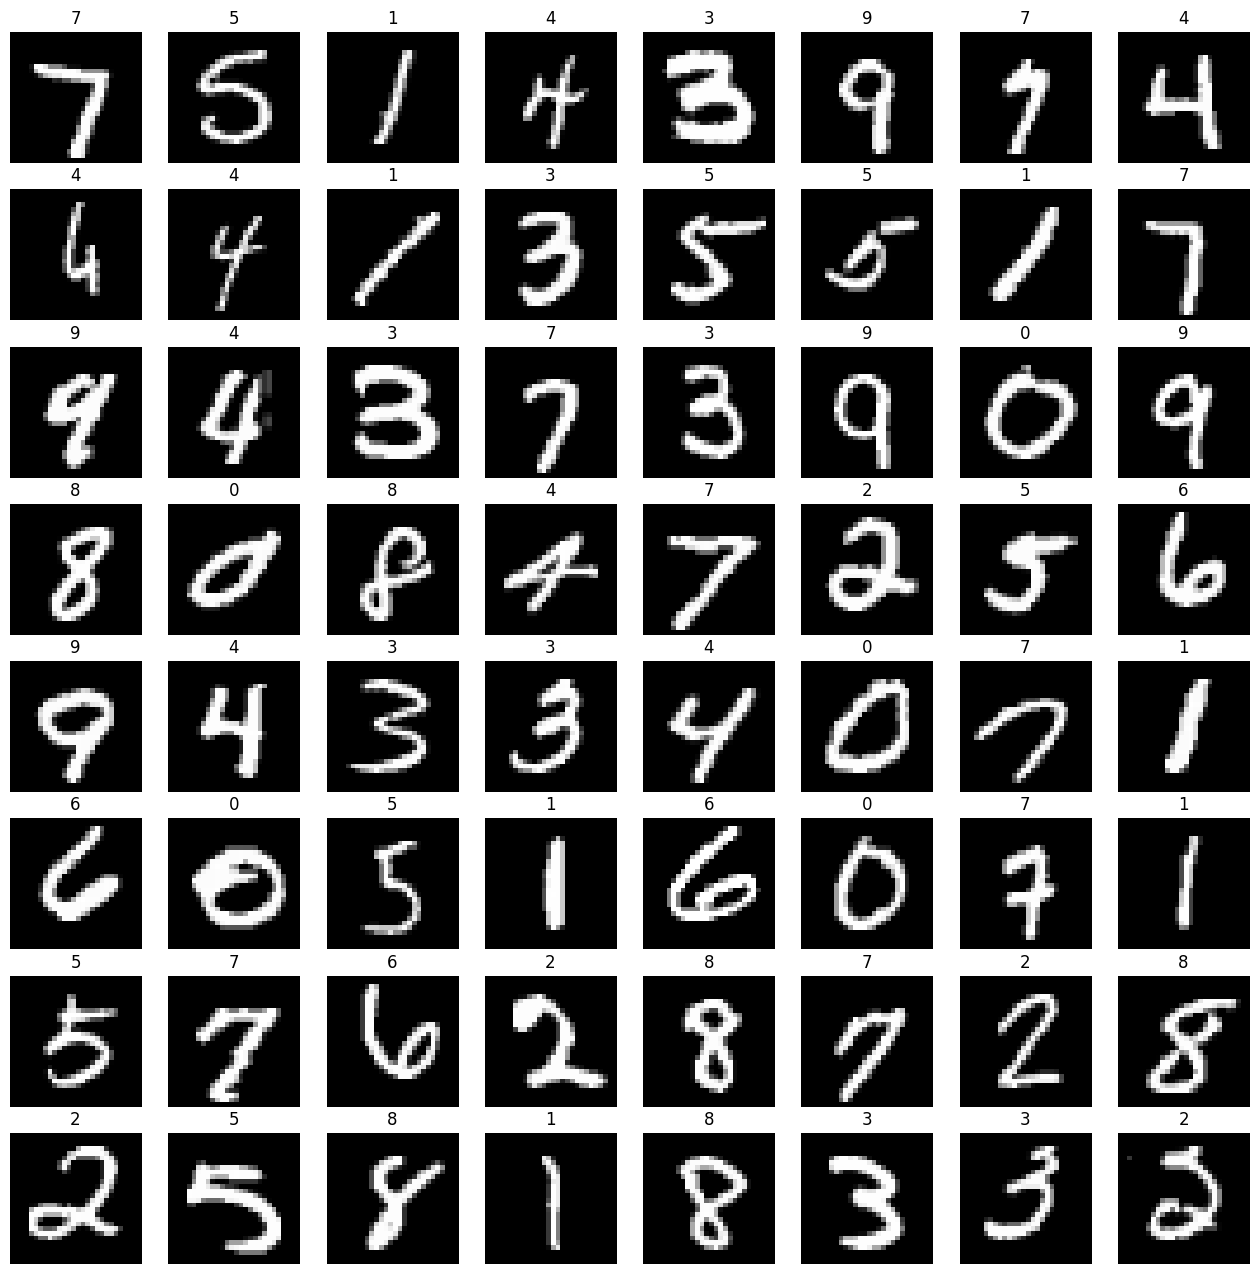

In [33]:
loader = DataLoader(
    dataset=train_data,
    batch_size=64,
    shuffle=True
)

imgs, labels = next(iter(loader))
fig, axes = plt.subplots(8, 8, figsize=(16, 16))

for ax, img, label in zip(axes.flatten(), imgs, labels):
    ax.imshow(img.reshape((28, 28)), cmap='gray')
    ax.set_title(label.item())
    ax.axis('off')

In [34]:
model = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),

    nn.Conv2d(32, 64, kernel_size=3, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),

    nn.Flatten(),
    nn.Linear(64 * 7 * 7, 10)
 ).to(device)

print(model)

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=3136, out_features=10, bias=True)
)


In [35]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10
for epoch in range(epochs):
    sum_losses = 0
    sum_accs = 0
    for x_batch, y_batch in loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        y_pred = model(x_batch)
        loss = nn.CrossEntropyLoss()(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sum_losses = sum_losses + loss
        y_prob = nn.Softmax(1)(y_pred)
        y_pred_index = torch.argmax(y_prob, axis=1)
        acc = (y_batch == y_pred_index).float().sum() / len(y_batch) * 100
        sum_accs = sum_accs + acc
    avg_loss = sum_losses / len(loader)
    avg_acc = sum_accs / len(loader)
    print(f'Epoch {epoch:4d}/{epochs} Loss: {avg_loss:.6f} Accuracy: {avg_acc:.2f}%')

Epoch    0/10 Loss: 0.187045 Accuracy: 94.43%
Epoch    1/10 Loss: 0.055177 Accuracy: 98.32%


KeyboardInterrupt: 

In [ ]:
test_loader = DataLoader(
    dataset=test_data,
    batch_size=64,
    shuffle=True
)

imgs, labels = next(iter(test_loader))
fig, axes = plt.subplots(8, 8, figsize=(16, 16))

for ax, img, label in zip(axes.flatten(), imgs, labels):
    ax.imshow(img.reshape((28, 28)), cmap='gray')
    ax.set_title(label.item())
    ax.axis('off')

In [ ]:
model.eval() # 모델을 테스트 모드로 전환

sum_accs = 0

for x_batch, y_batch in test_loader:
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    y_pred = model(x_batch)
    y_prob = nn.Softmax(1)(y_pred)
    y_pred_index = torch.argmax(y_prob, axis=1)
    acc = (y_batch == y_pred_index).float().sum() / len(y_batch) * 100
    sum_accs = sum_accs + acc

avg_acc = sum_accs / len(test_loader)
print(f'Test Accuracy: {avg_acc:.2f}%')

### 0, X, 세모 을 그림판에 여러가지 이미지를 저장 후 CNN으로 학습을 시켜 해당 데이터를 분류를 하는 모델을 만들어보자.



In [36]:
# PyTorch에서 텐서를 생성하는 코드. 이 코드는 이미지 데이터를 CNN 모델에 입력할 준비를 하는 단계
inputs = torch.Tensor(1, 1, 28, 28)
print(inputs.shape)

torch.Size([1, 1, 28, 28])


* 1 (첫 번째): 배치 크기 (여기서는 1개의 이미지를 의미)
* 1 (두 번째): 채널 수 (여기서는 그레이스케일 이미지를 의미, 만약 컬러 이미지라면 3이 됨)
* 28 (세 번째): 이미지의 높이 (픽셀 단위)
* 28 (네 번째): 이미지의 너비 (픽셀 단위)

In [37]:
# 첫번째 Conv2D
conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding='same')
out = conv1(inputs)
print(out.shape)

torch.Size([1, 32, 28, 28])


In [38]:
# 첫번째 MaxPool2D
pool = nn.MaxPool2d(kernel_size=2)
out = pool(out)
print(out.shape)

torch.Size([1, 32, 14, 14])


In [39]:
# 두번째 Conv2D
conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='same')
out = conv2(out)
print(out.shape)

torch.Size([1, 64, 14, 14])


In [40]:
# 두번째 MaxPool2D
pool = nn.MaxPool2d(kernel_size=2)
out = pool(out)
print(out.shape)

torch.Size([1, 64, 7, 7])


In [41]:
flatten = nn.Flatten()
out = flatten(out)
print(out.shape) # 64 * 7 * 7

torch.Size([1, 3136])


In [42]:
fc = nn.Linear(3136, 10)
out = fc(out)
print(out.shape)

torch.Size([1, 10])


In [43]:
import os
from PIL import Image

In [44]:
class CustomImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir)]
        self.label_map = {'0': 0, 'X': 1, 'Δ': 2}  # 레이블 매핑

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")  # 이미지를 RGB로 변환
        label = img_path.split('/')[-1][0]  # 파일명에서 레이블 추출 (예: '0_0.png'의 경우 '0' 추출)
        label = self.label_map[label]  # 레이블을 숫자로 매핑
        if self.transform:
            image = self.transform(image)
        return image, label


# 이미지 전처리 변환
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 컬러 이미지 정규화
])

# 학습 데이터셋 경로
train_image_dir = '/content/drive/MyDrive/KDT/6. 머신러닝과 딥러닝/Data/hand_drawn_symbol_images'
test_image_dir = '/content/drive/MyDrive/KDT/6. 머신러닝과 딥러닝/Data/hand_drawn_symbol_images_test'

# 학습 데이터셋 및 데이터로더 생성
train_dataset = CustomImageDataset(train_image_dir, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 테스트 데이터셋 및 데이터로더 생성
test_dataset = CustomImageDataset(test_image_dir, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)



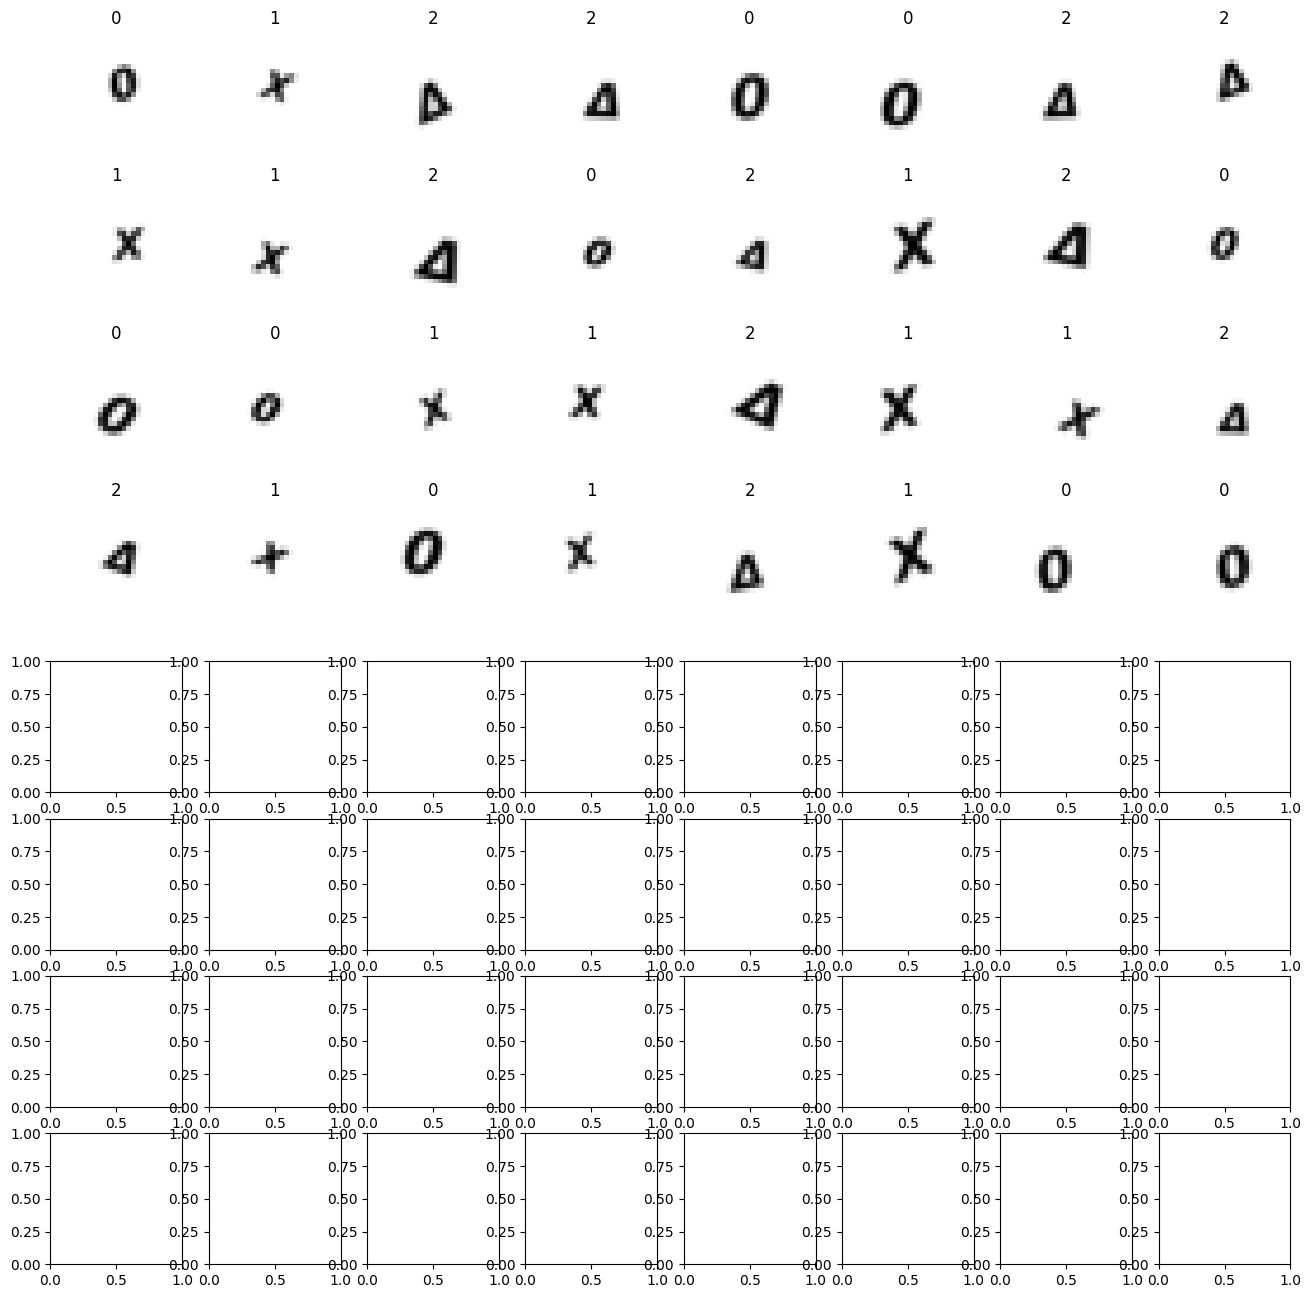

In [45]:
# 데이터셋 및 데이터로더 생성
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 데이터로더에서 배치 가져오기
imgs, labels = next(iter(train_dataloader))

# 이미지 시각화
fig, axes = plt.subplots(8, 8, figsize=(16, 16))

for ax, img, label in zip(axes.flatten(), imgs, labels):
    img = img.permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)로 변환
    img = (img - img.min()) / (img.max() - img.min())  # 이미지 데이터를 [0, 1] 범위로 정규화
    ax.imshow(img)
    ax.set_title(label.item())
    ax.axis('off')

In [48]:
model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, padding='same'),  # in_channels를 3으로 변경
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),

    nn.Conv2d(32, 64, kernel_size=3, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),

    nn.Flatten(),
    nn.Linear(64 * 7 * 7, 3)  # 10에서 3으로 변경 (클래스 수가 3개이므로)
).to(device)

print(model)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=3136, out_features=3, bias=True)
)


In [49]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10
for epoch in range(epochs):
    sum_losses = 0
    sum_accs = 0
    for x_batch, y_batch in train_dataloader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        y_pred = model(x_batch)
        loss = nn.CrossEntropyLoss()(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sum_losses = sum_losses + loss
        y_prob = nn.Softmax(1)(y_pred)
        y_pred_index = torch.argmax(y_prob, axis=1)
        acc = (y_batch == y_pred_index).float().sum() / len(y_batch) * 100
        sum_accs = sum_accs + acc
    avg_loss = sum_losses / len(train_dataloader)
    avg_acc = sum_accs / len(train_dataloader)
    print(f'Epoch {epoch:4d}/{epochs} Loss: {avg_loss:.6f} Accuracy: {avg_acc:.2f}%')

Epoch    0/10 Loss: 1.143638 Accuracy: 29.57%
Epoch    1/10 Loss: 1.086603 Accuracy: 40.14%
Epoch    2/10 Loss: 1.102749 Accuracy: 42.23%
Epoch    3/10 Loss: 1.082718 Accuracy: 35.58%
Epoch    4/10 Loss: 1.063570 Accuracy: 56.41%
Epoch    5/10 Loss: 1.048723 Accuracy: 61.14%
Epoch    6/10 Loss: 1.029022 Accuracy: 68.67%
Epoch    7/10 Loss: 1.006891 Accuracy: 58.33%
Epoch    8/10 Loss: 0.967366 Accuracy: 63.46%
Epoch    9/10 Loss: 0.943511 Accuracy: 64.58%


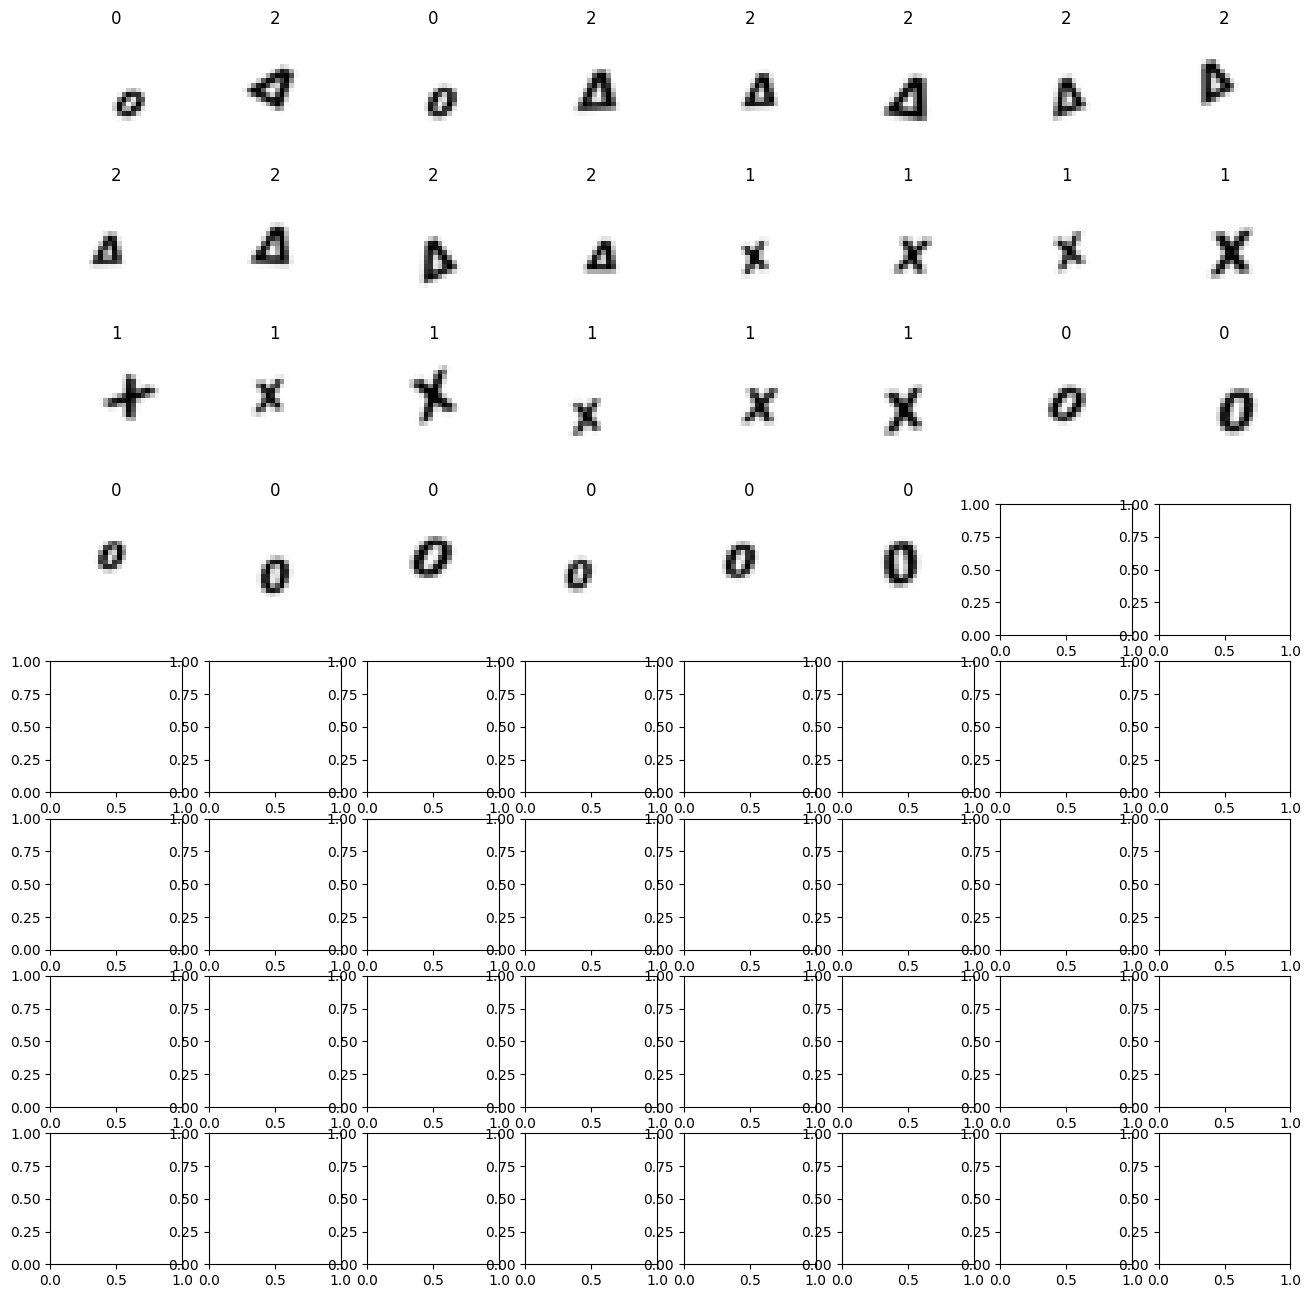

In [50]:
# 데이터셋 및 데이터로더 생성
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 데이터로더에서 배치 가져오기
imgs, labels = next(iter(test_dataloader))

# 이미지 시각화
fig, axes = plt.subplots(8, 8, figsize=(16, 16))

for ax, img, label in zip(axes.flatten(), imgs, labels):
    img = img.permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)로 변환
    img = (img - img.min()) / (img.max() - img.min())  # 이미지 데이터를 [0, 1] 범위로 정규화
    ax.imshow(img)
    ax.set_title(label.item())
    ax.axis('off')

In [51]:
model.eval() # 모델을 테스트 모드로 전환

sum_accs = 0

for x_batch, y_batch in test_dataloader:
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    y_pred = model(x_batch)
    y_prob = nn.Softmax(1)(y_pred)
    y_pred_index = torch.argmax(y_prob, axis=1)
    acc = (y_batch == y_pred_index).float().sum() / len(y_batch) * 100
    sum_accs = sum_accs + acc

avg_acc = sum_accs / len(test_dataloader)
print(f'Test Accuracy: {avg_acc:.2f}%')

Test Accuracy: 63.33%
